<a href="https://colab.research.google.com/github/shairatabassum/PyTorch_Learning/blob/main/PyTorch_V.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning with PyTorch** (part V)
A PyTorch notebook that I created while learning PyTorch through a series of tutorials on YouTube.

Source: [PyTorch Tutorials - Complete Beginner Course](https://www.youtube.com/watch?v=EMXfZB8FVUA&list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4)


> **Table of contents**
> *  Recurrent Neural Network (RNN)
> *  Gated Recurrent Unit (GRU)
> *  Long Short-Term Memory (LSTM)

In [1]:
# import libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
# hyper parameters
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.001

input_size = 28
sequence_length = 28
hidden_size = 128
num_layers = 2 # stacking two RNNs here

In [3]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='.data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='.data/', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/train-images-idx3-ubyte.gz to .data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/train-labels-idx1-ubyte.gz to .data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/t10k-images-idx3-ubyte.gz to .data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/t10k-labels-idx1-ubyte.gz to .data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
# print one batch of the data
examples = iter(train_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape)

torch.Size([100, 1, 28, 28]) torch.Size([100])


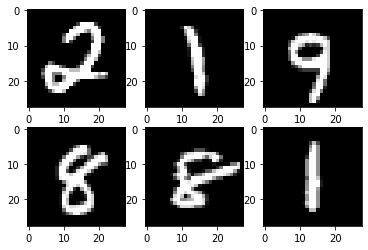

In [5]:
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.imshow(samples[i][0], cmap='gray')
plt.show()

### **Recurrent Neural Networks (RNN)**
RNNs are a class of neural networks that allow previous outputs to be used as inputs while having hidden states. The core reason that RNNs are so exciting is that they allow us to operate over sequences of vectors.

In [6]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # x --> (batch_size, seq, input_size)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # x: (n, 28, 28), h0: (2, n, 128)
        
        # Forward propagate RNN
        out, _ = self.rnn(x, h0)  
        # out: batch_size, seq_length, hidden_size
        # out (N, 28, 128)

        # Decode the hidden state of the last time step
        out = out[:, -1, :]
        # out: (n, 128)
         
        out = self.fc(out)
        # out: (n, 10)
        return out

model = RNN(input_size, hidden_size, num_layers, num_classes)

In [7]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [N, 1, 28, 28]
        # resized: [N, 28, 28]
        images = images.reshape(-1, sequence_length, input_size)
        labels = labels
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/2], Step [100/600], Loss: 0.9859
Epoch [1/2], Step [200/600], Loss: 0.5020
Epoch [1/2], Step [300/600], Loss: 0.7018
Epoch [1/2], Step [400/600], Loss: 0.5950
Epoch [1/2], Step [500/600], Loss: 0.2512
Epoch [1/2], Step [600/600], Loss: 0.5027
Epoch [2/2], Step [100/600], Loss: 0.3382
Epoch [2/2], Step [200/600], Loss: 0.3128
Epoch [2/2], Step [300/600], Loss: 0.2384
Epoch [2/2], Step [400/600], Loss: 0.2612
Epoch [2/2], Step [500/600], Loss: 0.2353
Epoch [2/2], Step [600/600], Loss: 0.2271


In [8]:
# Test the model
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size)
        labels = labels
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Accuracy of the network on the 10000 test images: 93.41 %


### **Gated Recurrent Unit(GRU)**

In [9]:
class RNN_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN_GRU, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        # x --> (batch_size, seq, input_size)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # x: (n, 28, 28), h0: (2, n, 128)
        
        # Forward propagate RNN_GRU
        out, _ = self.gru(x, h0)  
        # out: batch_size, seq_length, hidden_size
        # out (N, 28, 128)

        # Decode the hidden state of the last time step
        out = out[:, -1, :]
        # out: (n, 128)
         
        out = self.fc(out)
        # out: (n, 10)
        return out

model = RNN_GRU(input_size, hidden_size, num_layers, num_classes)

In [10]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [N, 1, 28, 28]
        # resized: [N, 28, 28]
        images = images.reshape(-1, sequence_length, input_size)
        labels = labels
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/2], Step [100/600], Loss: 0.6617
Epoch [1/2], Step [200/600], Loss: 0.4675
Epoch [1/2], Step [300/600], Loss: 0.2267
Epoch [1/2], Step [400/600], Loss: 0.2097
Epoch [1/2], Step [500/600], Loss: 0.3552
Epoch [1/2], Step [600/600], Loss: 0.1323
Epoch [2/2], Step [100/600], Loss: 0.1196
Epoch [2/2], Step [200/600], Loss: 0.3623
Epoch [2/2], Step [300/600], Loss: 0.1308
Epoch [2/2], Step [400/600], Loss: 0.0456
Epoch [2/2], Step [500/600], Loss: 0.0747
Epoch [2/2], Step [600/600], Loss: 0.0515


In [11]:
# Test the model
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size)
        labels = labels
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Accuracy of the network on the 10000 test images: 97.26 %


### **Long Short-Term Memory (LSTM)**

In [12]:
class RNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN_LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # x --> (batch_size, seq, input_size)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # x: (n, 28, 28), h0: (2, n, 128)
        
        # Forward propagate RNN_LSTM
        out, _ = self.lstm(x, (h0, c0))  
        # out: batch_size, seq_length, hidden_size
        # out (N, 28, 128)

        # Decode the hidden state of the last time step
        out = out[:, -1, :]
        # out: (n, 128)
         
        out = self.fc(out)
        # out: (n, 10)
        return out

model = RNN_LSTM(input_size, hidden_size, num_layers, num_classes)

In [13]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [N, 1, 28, 28]
        # resized: [N, 28, 28]
        images = images.reshape(-1, sequence_length, input_size)
        labels = labels
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/2], Step [100/600], Loss: 0.6228
Epoch [1/2], Step [200/600], Loss: 0.4546
Epoch [1/2], Step [300/600], Loss: 0.2557
Epoch [1/2], Step [400/600], Loss: 0.1395
Epoch [1/2], Step [500/600], Loss: 0.2057
Epoch [1/2], Step [600/600], Loss: 0.0926
Epoch [2/2], Step [100/600], Loss: 0.0410
Epoch [2/2], Step [200/600], Loss: 0.1320
Epoch [2/2], Step [300/600], Loss: 0.0312
Epoch [2/2], Step [400/600], Loss: 0.1357
Epoch [2/2], Step [500/600], Loss: 0.1147
Epoch [2/2], Step [600/600], Loss: 0.0821


In [14]:
# Test the model
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size)
        labels = labels
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Accuracy of the network on the 10000 test images: 97.52 %
